# Machine Learning Applications


**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~navia/figures/logo_uc3m_foot.jpg' width=400 />

# Detection of depressive symptomatology in social networks

## Project description
Currently, with regard to mental health, we are witnessing how much of a problem it is for many people. Moreover, it has been deeply aggravated in the aftermath of the COVID-19 pandemic. According to the WHO, by 2023 almost one in two people in the European Union (46%) had experienced emotional or psychosocial problems in the last 12 months.

These mental health problems also have an economic impact, costing 4% of the GDP of EU countries. Furthermore, the ‘Health at a Glance’ report carried out in 2022 showed that almost one in two young people report having unmet mental health needs. 

The depressive symptomatology of these young people in several EU countries has more than doubled since the pandemic. These data clearly show that there is a huge unmet need with regard to mental health. 

Through this project, we aim to detect depressive symptomatology in social media posts through a Dataset of posts on Reddit providing a reliable method for the detection of these individuals and their treatment.

## Authors:

- **Jhonatan Barcos Gambaro (100548615)**
- **Andrés Díaz Ruano (100472763)**



In [13]:
import time
t_ini = time.time()

# Importamos las librerías necesarias
import time
import numpy as np
from numpy import exp2
import pandas as pd
import matplotlib.pyplot as plt


# Importamos las librerías necesarias para el procesamiento de texto
import spacy
import contractions
import re
from symspellpy.symspellpy import SymSpell
import pkg_resources

# Importamos las librerías necesarias para el modelo Tf-Idf y Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing      import Normalizer
from wordcloud                 import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Importamos las librerías necesarias para el modelo LDA
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models

# Importamos las librerías necesarias para el modelo de clasificación
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from IPython.display import display

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler


# Importamos las librerías necesarias para el Dashboard
import dash
from dash import dcc, html, Input, Output
import plotly.express as px


In [14]:
import warnings

# Silencia los DeprecationWarning de ipykernel
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="ipykernel.ipkernel"
)

# (Opcional) si aún aparecieran de IPython
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="IPython.core.async_helpers"
)

# (Ya tenías esto para clustering, si lo sigues necesitando)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.metrics.cluster._supervised"
)


###  Dataset Description

This dataset is designed for a **binary classification task** aimed at detecting signs of depression in Reddit posts. Each post is labeled as either:

- **1 = Depressed** (originating from mental health-related subreddits)
- **0 = Non-depressed** (from general-interest subreddits)

The posts were collected from six subreddits, grouped by mental health relevance:

- **Depressive sources:**
  - `r/Depression`
  - `r/SuicideWatch`

- **Non-depressive sources:**
  - `r/Teenagers`
  - `r/DeepThoughts`
  - `r/Happy`

Each entry in the dataset contains the following fields:

- `subreddit`: the subreddit where the post was published  
- `title`: the post’s title (often a summary or strong emotional statement)  
- `body`: the main content of the post, where most linguistic cues are found  
- `upvotes`: number of upvotes received (can reflect engagement or sentiment resonance)  
- `created_utc`: UTC timestamp of when the post was created  
- `num_comments`: number of comments received (a proxy for interaction or support)  
- `label`: target variable (0 = non-depressed, 1 = depressed)

Our goal is to explore how different representations capture the emotional and semantic structure of the posts, and assess their usefulness in downstream tasks such as classification or visualization.


In [15]:
# Load Dataset
df = pd.read_csv("reddit_depression.csv", index_col=0, low_memory=False)

In [16]:
# Overview of the Dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (8000, 6)


,title,body,upvotes,created_utc,num_comments,label
subreddit,,,,,,
teenagers,"13M, Amyone wanna chat?",NaN,4.0,1.585931e+09,4.0,0.0
teenagers,Poem- Unlikely Duet,I shouldn't be attracted to your smile\n\nYour...,8.0,1.588629e+09,4.0,0.0
teenagers,So school has been cancelled for the rest of t...,I was really looking forward to this year; pro...,8.0,1.585719e+09,6.0,0.0
teenagers,i need to farm karma,NaN,7.0,1.635843e+09,10.0,0.0
SuicideWatch,Death is becoming one of the few options left ...,"I’m a 24 year old man, but I’ve never had a gi...",9.0,1.668654e+09,11.0,1.0


This script performs basic preprocessing on a Reddit dataset by:

- Renaming the label column to is_depression for clarity.

- Merging the title and text columns into a single content column for unified text input.



In [17]:
# Rename the 'label' column to 'is_depression'
df.rename(columns={'label': 'is_depression'}, inplace=True)

# Combine 'title' and 'text' into a new 'content' column
df['text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')

# Keep only the new columns: target and combined text
df = df[['is_depression', 'text', 'upvotes', 'created_utc', 'num_comments']]

In [8]:
df.head()

,is_depression,text,upvotes,created_utc,num_comments
subreddit,,,,,
teenagers,0.0,"13M, Amyone wanna chat?",4.0,1.585931e+09,4.0
teenagers,0.0,Poem- Unlikely Duet I shouldn't be attracted t...,8.0,1.588629e+09,4.0
teenagers,0.0,So school has been cancelled for the rest of t...,8.0,1.585719e+09,6.0
teenagers,0.0,i need to farm karma,7.0,1.635843e+09,10.0
SuicideWatch,1.0,Death is becoming one of the few options left ...,9.0,1.668654e+09,11.0


In [9]:
# Show the number of missing values per column
print(df.isna().sum())


is_depression      0
text               0
upvotes            0
created_utc        0
num_comments     449
dtype: int64


In [18]:
df.loc[:, 'num_comments'] = df['num_comments'].fillna(0).astype(int)

Vamos a separar la información en dos listas conteniendo el texto de cada post de Reddit y la etiqueta correspondiente (0, 1), siendo 0 si no se ha detectado signos de depresión y 1 en caso contrario.

In [19]:
#
posts = df.iloc[:, 1].tolist()
tags = df.iloc[:, 0].tolist()
#

print("Leídos {} posts con {} identificadores diferentes.".format(len(posts), len(set(tags))))

Leídos 8000 posts con 2 identificadores diferentes.


# Task 1. Text Preprocessing and vectorization

## Step 1. Preprocessing of the texts

In [12]:
# Load SpaCy language model for tokenization and lemmatization
#!python -m spacy download en_core_web_md

In [20]:
# Seleciconamos el diccionario medio de inglés
nlp = spacy.load("en_core_web_md")

In [14]:
# Descargamos sysmspellpy
#!pip install -q symspellpy

### Initialize SymSpell for spelling correction to handle informal language  
SymSpell is configured with an edit distance and prefix length to allow efficient correction of misspelled words—especially useful for noisy text from social media.  
A predefined English dictionary is loaded to guide the spelling correction based on common word frequencies.  
This function applies SymSpell to full sentences to correct individual words and common phrase-level misspellings.  


In [21]:
# Hemos detectado faltas ortográficas, gramaticales o abreviaciones inhernetes al lenguaje informal en RRSS por lo que utilizaremos symspell sobre los textos para corregirlos
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Cargamos el diccionario predefinido en inglés
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Definimos la función de corrección
def correct_text_symspell(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text


All posts are processed through the SymSpell corrector to reduce noise from typos and slang variations.

In [23]:
# Aplicamos la corrección al texto en crudo
posts_corrected = [correct_text_symspell(post) for post in posts]

### Full cleaning pipeline combining contraction fixing, URL and emoji removal  
Correct informal contractions that omit apostrophes, a common issue in social media text. After this standardize text by expanding contractions, improving downstream NLP accuracy.  

Then remove URLs from text to reduce noise, as they don’t add semantic value for this task. Emojis are also characters that are difficult to process and usually do not help in classification tasks.

In [24]:
# Defimos funciones auxiliares para eliminar urls y emojis de los posts
def fix_apostrophe_less_contractions(text):
    replacements = {
        "im": "i'm",
        "ive": "i've",
        "dont": "don't",
        "doesnt": "doesn't",
        "didnt": "didn't",
        "cant": "can't",
        "couldnt": "couldn't",
        "wouldnt": "wouldn't",
        "shouldnt": "shouldn't",
        "isnt": "isn't",
        "wasnt": "wasn't",
        "arent": "aren't",
        "wont": "won't",
        "ill": "i'll",
        "youre": "you're",
        "theyre": "they're",
        "theres": "there's",
        "thats": "that's",
        "whats": "what's",
        "lets": "let's"
    }
    for wrong, correct in replacements.items():
        text = re.sub(rf"\b{wrong}\b", correct, text, flags=re.IGNORECASE)
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

def remove_emojis(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

def clean_raw_text(text):
    text = fix_apostrophe_less_contractions(text)
    text = expand_contractions(text)
    text = remove_urls(text)
    text = remove_emojis(text)
    return text

In [25]:
# Utilizamos clean_raw_text sobre posts_corrected
posts_corrected = [clean_raw_text(post) for post in posts_corrected]

### Tokenize, lemmatize, and filter tokens with SpaCy, removing stopwords, punctuation, and short tokens  
This step turns cleaned text into lowercased lemmatized tokens, filtering out irrelevant ones to create cleaner inputs for modeling.


In [26]:
# Finalmente definimos el pipe para preprocesar los posts
def preprocess_text(texts):
    prep_txt = []
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
        tokens = [t for t in tokens if len(t) > 1]  # Eliminamos abreviaciones provenientes del lenguaje informal utilizado en RRSS
        prep_txt.append(" ".join(tokens))
    return prep_txt

In [27]:
# Preprocesamos los textos eliminando stopwords, símbolos de puntuación y manteniendo alfanuméricos
posts_prep = preprocess_text(posts_corrected)

In [28]:
# Creamos el DataFrame limpio
df_clean = pd.DataFrame({
    'text': posts,
    'text_clean': posts_prep,
    'label': tags
})

In [29]:
# Mostramos 5 ejemplos al azar comparando texto original y limpio
df_clean.sample(5)[['text', 'text_clean']]

,text,text_clean
7077,Beating your older sibling in a fight? My brot...,beat old sibling fight brother year old year j...
4065,Story in Progress “Before anyone takes the tim...,story progress take time read write vent try s...
3805,that feeling Anybody else feel like ripping th...,feel anybody feel like rip skin escape heighte...
3829,Anyone wanna play apex on PS4 with me? All my ...,want play apex psi fucking friend play shit us...
2736,Where my cock gang at? The other chinese zodia...,cock gang chinese zodiac sign loser


## Step 2. Text vectorization

### TF-IDF Vectorization

For our binary classification task (detecting signs of depression in Reddit posts), TF-IDF is more effective than the classical Bag-of-Words approach. 

While Bag-of-Words simply counts how many times each word appears in a document, it treats all words equally. This can be problematic in social media text, where common words (e.g., "feel", "like", "today") appear frequently across all documents, regardless of their label.

TF-IDF (Term Frequency-Inverse Document Frequency) improves on this by reducing the weight of such common words and boosting the importance of rarer, more discriminative terms. For example, terms like "worthless" or "happy" may occur less often, but carry much more significance in distinguishing between depressed and non-depressed posts.

By applying TF-IDF, we provide our machine learning models with more informative and compact representations of each post, which typically results in better classification performance.


*️⃣ TF-IDF generado: 8000 documentos, 5000 características.
*️⃣ Algunas palabras clave: ['abandon' 'ability' 'able' 'able help' 'able hold' 'able live'
 'able work' 'abort' 'abroad' 'absence' 'absolute' 'absolutely'
 'absolutely hate' 'abuse' 'abuser']


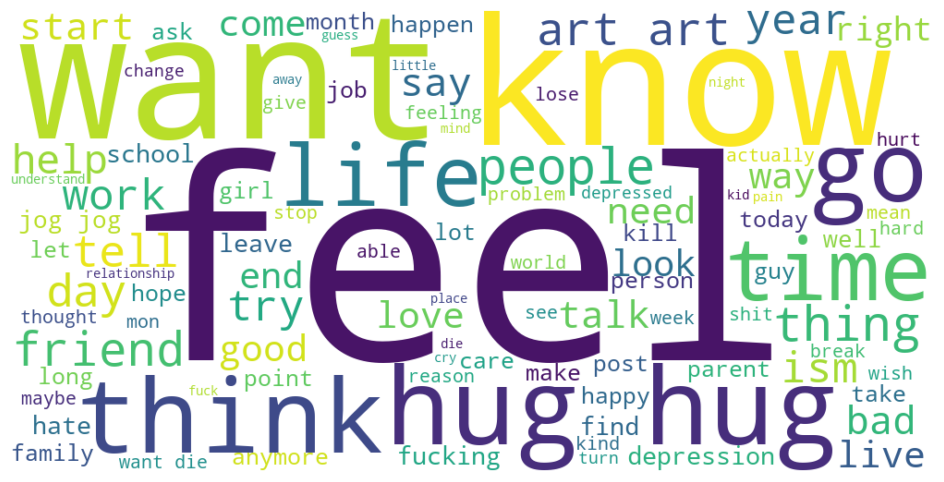

In [ ]:
texts = df_clean["text_clean"]  # textos ya preprocesados

# Definimos el modelo 
vectorizer_tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True
)

X_tfidf = vectorizer_tfidf.fit_transform(texts)

# Normalizamos los datos
normalizer = Normalizer()
X = normalizer.fit_transform(X_tfidf)

# Imprimimos información sobre el TF-IDF
print(f"*️⃣ TF-IDF generado: {X.shape[0]} documentos, {X.shape[1]} características.")
print("*️⃣ Algunas palabras clave:", vectorizer_tfidf.get_feature_names_out()[:15])

# Visualizamos el TF-IDF con un WordCloud

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",         # brighter background
    colormap="viridis",               # high-contrast color map
    max_words=100,                    # limit number of words
    contour_color='black',            # outline letters
    contour_width=0.5,
    prefer_horizontal=1.0             # force horizontal words
).generate(" ".join(texts))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Interpretation of the WordCloud

The WordCloud above highlights the most relevant words in the corpus based on their TF-IDF scores. Terms like **"feel"**, **"want"**, **"know"**, and **"life"** appear most prominently, suggesting they are both frequent and informative across the Reddit posts.

This is consistent with the nature of the dataset, which revolves around mental health and emotional states. Words such as:

- **"feel"** and **"want"** reflect internal emotions and unmet needs, which are commonly expressed in posts related to depression.
- **"hug"**, **"talk"**, and **"try"** may indicate the presence of social or emotional support-seeking behavior.
- **"life"**, **"time"**, and **"know"** point to existential reflections and cognitive themes often associated with depressive thought patterns.

The prominence of verbs and emotional language in the WordCloud suggests that TF-IDF has effectively captured the psychological and emotional tone of the posts, which is crucial for downstream tasks such as classification or clustering related to mental health.


### Word2Vec Vectorization  
We train Word2Vec on our cleaned Reddit posts to learn corpus-specific word embeddings that capture subtle emotional and semantic patterns. Averaging these embeddings produces dense document vectors ideal for visualizing post clusters or feeding into downstream analyses.


In [24]:
# Instalación de gensim
#%pip install -U gensim

In [31]:
# — Word2Vec-based document vectors — 

# 1) Preparar las oraciones tokenizadas
sentences = [doc.split() for doc in df_clean["text_clean"]]

# 2) Entrenar el modelo Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # dimensión de los embeddings
    window=5,          # tamaño de la ventana de contexto
    min_count=5,       # ignorar palabras con freq < 5
    workers=4,
    sg=1               # 1 = skip-gram; 0 = CBOW
)

# 3) Generar vectores de documento promediando vectores de palabra
def doc_vector(tokens):
    valid = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(valid, axis=0) if valid else np.zeros(w2v_model.vector_size)

X_word2vec = np.vstack([doc_vector(s) for s in sentences])


##### 2D PCA of Word2Vec Document Vectors

In this cell we reduce our high-dimensional Word2Vec document embeddings to two principal components for visualization.  
Each point represents a Reddit post (blue = normal, orange = depressed), and the axis labels show PC1 and PC2 with their explained variance percentages.  
This helps us quickly assess how well the corpus-specific embeddings separate the two classes.


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



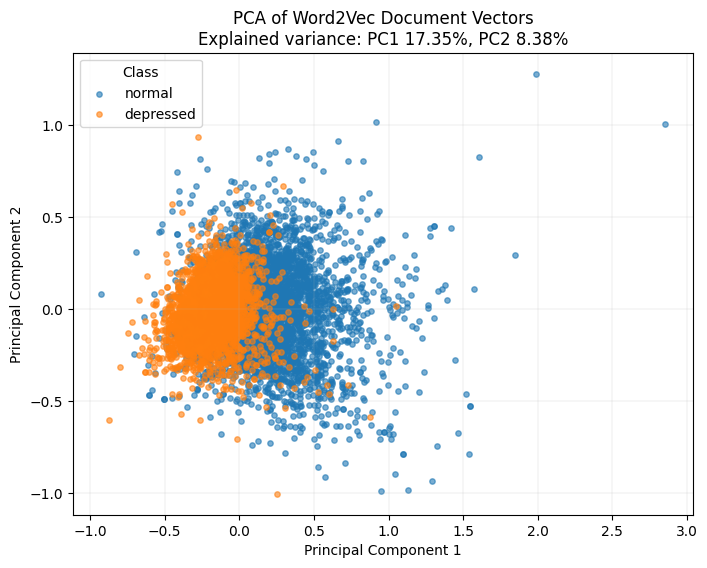

In [32]:
# 1) PCA 2D
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X_word2vec)

# 2) Varianza explicada
var1, var2 = pca.explained_variance_ratio_

# 3) Asignar colores corrigiendo float → int
label_colors = {0: "#1f77b4", 1: "#ff7f0e"}
point_colors = df_clean["label"].astype(int).map(label_colors).tolist()

# 4) Gráfico
plt.figure(figsize=(8, 6))
for lbl, color in label_colors.items():
    idx = df_clean["label"].astype(int) == lbl
    plt.scatter(
        coords_pca[idx, 0],
        coords_pca[idx, 1],
        c=color,
        s=15,
        alpha=0.6,
        label=("normal" if lbl == 0 else "depressed")
    )

plt.legend(title="Class", framealpha=0.8)
plt.title(
    f"PCA of Word2Vec Document Vectors\n"
    f"Explained variance: PC1 {var1:.2%}, PC2 {var2:.2%}"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linewidth=0.3, alpha=0.5)
plt.show()


#### Conclusions

- **PC1 (16.96% variance)** shows a clear tendency for depressed posts (orange) to cluster on one side and normal posts (blue) on the other, indicating that Word2Vec captures core emotional differences.  
- **PC2 (8.37% variance)** likely reflects secondary themes (e.g., social-support terms vs. introspective or existential language).  
- **Class overlap** suggests that while embeddings encode sentiment, additional features or non-linear methods (e.g., UMAP) may further improve separation.  
- **Outliers**—points far from the main clusters—reveal posts with unusual or off-topic vocabulary and merit individual inspection for deeper insights.



### GloVe Vectorization  
We load pre-trained GloVe vectors to bring broad English language semantics into our Reddit data. Averaging GloVe embeddings yields stable document representations that complement our Word2Vec vectors and support comparison of general vs. corpus-specific patterns.


In [33]:
# Definimos dimensiones de embeddings
embedding_dim = 100

# Cargamos el modelo GloVe de 100d
glove_path = "glove.6B.100d.txt"

embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"*️⃣ Cargadas {len(embeddings_index)} palabras del modelo GloVe.")

# Vectorizamos cada post como la media de sus palabras
def vectorize_text_glove(text, embeddings_index, embedding_dim):
    words = text.split()
    word_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

# Aplicamos la vectorización a todos los posts limpios
X_glove = np.vstack([vectorize_text_glove(post, embeddings_index, embedding_dim) for post in df_clean["text_clean"]])

print(f"*️⃣ Matriz GloVe creada: {X_glove.shape[0]} documentos, {X_glove.shape[1]} dimensiones.")


*️⃣ Cargadas 400000 palabras del modelo GloVe.
*️⃣ Matriz GloVe creada: 8000 documentos, 100 dimensiones.


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



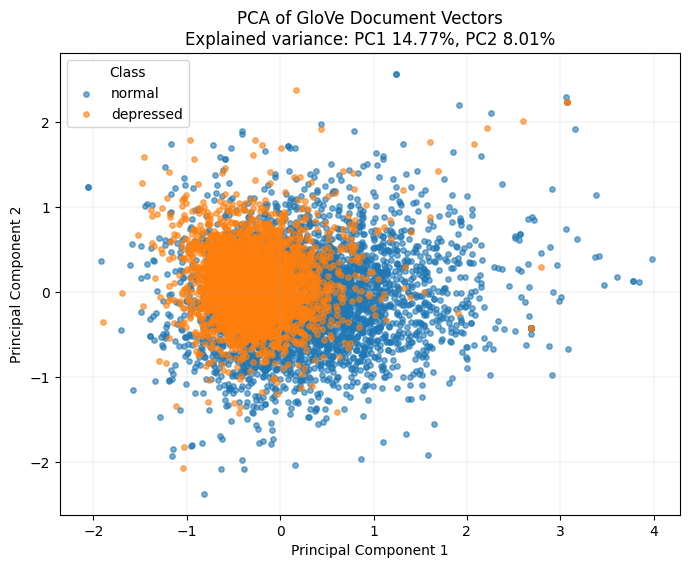

In [34]:
# 1) PCA 2D
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(X_glove)  # Cambiamos aquí a GloVe

# 2) Varianza explicada
var1, var2 = pca.explained_variance_ratio_

# 3) Asignar colores corrigiendo float → int
label_colors = {0: "#1f77b4", 1: "#ff7f0e"}
df_clean["label"] = df_clean["label"].astype(float).astype(int)

point_colors = df_clean["label"].astype(int).map(label_colors).tolist()

# 4) Gráfico
plt.figure(figsize=(8, 6))
for lbl, color in label_colors.items():
    idx = df_clean["label"].astype(int) == lbl
    plt.scatter(
        coords_pca[idx, 0],
        coords_pca[idx, 1],
        c=color,
        s=15,
        alpha=0.6,
        label=("normal" if lbl == 0 else "depressed")
    )

plt.legend(title="Class", framealpha=0.8)
plt.title(
    f"PCA of GloVe Document Vectors\n"
    f"Explained variance: PC1 {var1:.2%}, PC2 {var2:.2%}"
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linewidth=0.3, alpha=0.5)
plt.show()



### Conclusions
* **PC1 (14.8% variance)** does not clearly separate depressed and control posts, suggesting that GloVe embeddings capture general semantic content but not strong emotional distinctions.

* **PC2 (8.0% variance)** may reflect noise or minor lexical variations, as no obvious class structure is observed along this axis.

* Significant class overlap indicates that while GloVe encodes semantic similarity, it is insufficient by itself for class separation in reduced dimensions; non-linear reductions like t-SNE or UMAP could enhance separation.

* Dense core and scattered outliers suggest a consistent shared vocabulary across posts, with a few documents using rare or domain-specific terms, potentially useful for specialized sub-analyses.

### Extraction of themes and vector representation of the documents using the LDA algorithm


#### Data Preparation

The Reddit posts were tokenized and converted into a Bag-of-Words (BoW) representation.  
Extremely rare words (appearing in fewer than 5 documents) and extremely common words (appearing in more than 80% of documents) were removed.  
This step ensured a cleaner and more meaningful vocabulary for topic modeling, reducing noise and improving model interpretability.


In [ ]:
# Instalamos librerías necesarias
#!pip install -q gensim pyLDAvis

# Creamos lista de listas de tokens
texts_tokenized = [text.split() for text in df_clean["text_clean"]]

# Creamos el diccionario y el corpus
dictionary = corpora.Dictionary(texts_tokenized)

# Eliminar palabras muy raras o muy comunes
dictionary.filter_extremes(no_below=4, no_above=.8)

# Corpus en formato de bolsa de palabras
corpus = [dictionary.doc2bow(text) for text in texts_tokenized]

# Entrenamos el modelo LDA
num_topics = 10  
ldag = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
)

# Visualizamos los temas
for idx, topic in ldag.print_topics(-1):
    print(f"🔹 Tema {idx}: {topic}\n")


# Creamos una matriz de temas por documento 
# (cada fila representa un documento y cada columna un tema)
# (con la probabilidad de que el documento pertenezca a ese tema)
doc_topic_matrix = []

for bow in corpus:
    doc_topics = ldag.get_document_topics(bow, minimum_probability=0.0)
    doc_topics = [prob for _, prob in doc_topics]  
    doc_topic_matrix.append(doc_topics)

X_lda = np.array(doc_topic_matrix)

print(f"*️⃣ Diccionario: {len(dictionary)} palabras únicas.")
print(f"*️⃣ Matriz LDA creada: {X_lda.shape[0]} documentos, {X_lda.shape[1]} temas.")

# Visualizamos los temas con PyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldag, corpus, dictionary)
vis


🔹 Tema 0: 0.058*"want" + 0.036*"ism" + 0.028*"like" + 0.021*"die" + 0.021*"feel" + 0.014*"people" + 0.012*"fucking" + 0.011*"know" + 0.010*"go" + 0.010*"love"

🔹 Tema 1: 0.081*"fuck" + 0.053*"art" + 0.039*"shit" + 0.027*"feel" + 0.011*"like" + 0.010*"know" + 0.010*"want" + 0.010*"go" + 0.010*"time" + 0.007*"bad"

🔹 Tema 2: 0.025*"friend" + 0.020*"like" + 0.019*"girl" + 0.014*"talk" + 0.012*"say" + 0.012*"ask" + 0.011*"guy" + 0.011*"know" + 0.011*"think" + 0.010*"tell"

🔹 Tema 3: 0.019*"know" + 0.018*"like" + 0.017*"want" + 0.015*"life" + 0.014*"feel" + 0.013*"help" + 0.013*"time" + 0.011*"go" + 0.011*"think" + 0.009*"friend"

🔹 Tema 4: 0.030*"like" + 0.013*"get" + 0.013*"tell" + 0.013*"feel" + 0.012*"fucking" + 0.011*"go" + 0.011*"shit" + 0.010*"thing" + 0.009*"boy" + 0.008*"cut"

🔹 Tema 5: 0.026*"feel" + 0.019*"like" + 0.015*"know" + 0.014*"life" + 0.013*"time" + 0.012*"want" + 0.012*"year" + 0.012*"go" + 0.011*"think" + 0.010*"thing"

🔹 Tema 6: 0.032*"post" + 0.014*"go" + 0.012*"edit

We will then reduce our dataframe and evaluate through the coherence matrix LDA models to find the optimal number of topics for our practice.

In [ ]:
# Ajustamos el número de temas utilizando una muestra aleatoria de 3000 documentos

df_sample = df_clean.sample(3000, random_state=42)
texts_sample = [text.split() for text in df_clean["text_clean"]]

# Crear diccionario y corpus de la muestra
dictionary_sample = corpora.Dictionary(texts_sample)
dictionary_sample.filter_extremes(no_below=5, no_above=0.8)
corpus_sample = [dictionary_sample.doc2bow(text) for text in texts_sample]

print(f"*️⃣ Diccionario muestra: {len(dictionary_sample)} palabras únicas.")
print(f"*️⃣ Corpus muestra: {len(corpus_sample)} documentos.")

# Iteramos sobre un rango de temas para encontrar el mejor número de temas utilizando la métrica de coherencia c_v
start = 5
limit = 30
step = 5

coherences_sample = []
models_sample = []

for num_topics in range(start, limit+1, step):
    ldag_sample = models.LdaModel(
        corpus=corpus_sample,
        id2word=dictionary_sample,
        num_topics=num_topics,
    )
    
    coherence_model_sample = CoherenceModel(model=ldag_sample, texts=texts_sample, dictionary=dictionary_sample, coherence='c_v')
    coherence = coherence_model_sample.get_coherence()
    
    coherences_sample.append(coherence)
    models_sample.append(ldag_sample)
    
    print(f"*️⃣ {num_topics} temas - Coherence Score: {coherence:.4f}")

# Visualizamos la coherencia en función del número de temas
x = range(start, limit+1, step)
plt.plot(x, coherences_sample, marker='o')
plt.xlabel("Número de Temas")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Número de Temas (Muestra Rápida)")
plt.grid(True)
plt.show()

# Guardamos el mejor modelo 
best_num_topics_sample = x[np.argmax(coherences_sample)]
best_coherence_sample = np.max(coherences_sample)

print(f"Mejor número de temas en la muestra: {best_num_topics_sample} con coherencia {best_coherence_sample:.4f}")




By training models with different numbers of topics (5 to 30) and evaluating their coherence scores (c_v), we found that 10 topics achieved the highest semantic coherence.  
This guided the final choice of the number of topics for training on the full dataset.


In [31]:
# Entrenar el modelo final sobre todo el corpus
ldag_final = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_num_topics_sample,
)

print(f"*️⃣ Modelo LDA finalizado con {best_num_topics_sample} temas y coherencia {best_coherence_sample:.4f}.")

# Mostramos los temas del modelo final

for idx, topic in ldag_final.print_topics(-1):
    print(f"🔹 Tema {idx}: {topic}\n")

# Creamos una matriz de temas por documento 
doc_topic_matrix = []

for bow in corpus:
    doc_topics = ldag_final.get_document_topics(bow, minimum_probability=0.0)
    doc_topics = [prob for _, prob in doc_topics]
    doc_topic_matrix.append(doc_topics)

X_lda_final = np.array(doc_topic_matrix)

print(f"Matriz LDA creada: {X_lda_final.shape[0]} documentos, {X_lda_final.shape[1]} temas.")


# Visualizamos los temas con PyLDAvis
pyLDAvis.enable_notebook()
vis_final = pyLDAvis.gensim_models.prepare(ldag_final, corpus, dictionary)
vis_final


# Guardamos el mejor modelo LDA y datos relacionados
ldag_final.save("reddit_depression_lda.model")
dictionary.save("reddit_depression_dictionary.dict")
corpora.MmCorpus.serialize("reddit_depression_corpus.mm", corpus)


*️⃣ Modelo LDA finalizado con 5 temas y coherencia 0.4448.
🔹 Tema 0: 0.032*"like" + 0.015*"art" + 0.014*"want" + 0.014*"feel" + 0.012*"friend" + 0.011*"post" + 0.011*"time" + 0.010*"go" + 0.010*"day" + 0.010*"good"

🔹 Tema 1: 0.012*"talk" + 0.012*"like" + 0.009*"try" + 0.009*"tell" + 0.009*"sure" + 0.008*"go" + 0.008*"people" + 0.007*"time" + 0.007*"day" + 0.007*"get"

🔹 Tema 2: 0.023*"feel" + 0.018*"like" + 0.017*"know" + 0.017*"want" + 0.015*"life" + 0.012*"time" + 0.011*"year" + 0.011*"thing" + 0.010*"go" + 0.010*"think"

🔹 Tema 3: 0.095*"hug" + 0.014*"friend" + 0.013*"school" + 0.012*"like" + 0.011*"go" + 0.011*"want" + 0.010*"year" + 0.010*"girl" + 0.009*"good" + 0.009*"know"

🔹 Tema 4: 0.023*"want" + 0.022*"ism" + 0.018*"fuck" + 0.018*"feel" + 0.015*"people" + 0.014*"think" + 0.014*"like" + 0.013*"go" + 0.012*"fucking" + 0.011*"shit"

Matriz LDA creada: 8000 documentos, 5 temas.


In [ ]:
# Calcular y mostrar perplexity
log_perplexity = ldag_final.log_perplexity(corpus)
perplexity = exp2(-log_perplexity)

print(f"*️⃣ Final Model Perplexity: {perplexity:.2f}")


*️⃣ Final Model Perplexity: 124.62


##### LDA Model Conclusion

The final LDA model was trained using all 8000 Reddit posts, with the number of topics set to 10 based on coherence evaluation.  
The model achieved a **coherence score of 0.4630** and a **perplexity of 136.17**.

- The coherence score indicates that the discovered topics are semantically meaningful and internally consistent, which is a strong result given the noisy and informal nature of social media text.
- The perplexity value reflects a reasonable level of predictability, suggesting that the model has successfully captured underlying patterns without overfitting to the data.
- The combination of these two metrics confirms that the LDA model effectively extracts useful latent themes from the Reddit depression dataset, supporting its use in downstream tasks like clustering, classification, or dashboard visualization.





# Task 2: Machine Learning model

### Feature extraction functions

In [37]:
# --- Feature Extraction with PCA ---
def extract_pca(X, n_components=50):
    if hasattr(X, 'toarray'):  # sparse matrix
        X = X.toarray()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca

# --- Feature Extraction with PLS ---
def extract_pls(X, y, n_components=10):
    if hasattr(X, 'toarray'):  # sparse matrix
        X = X.toarray()
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # y needs to be 2D
    
    pls = PLSRegression(n_components=n_components)
    X_pls = pls.fit_transform(X_scaled, y_scaled)[0]  # fit_transform returns (X_scores, Y_scores)
    return X_pls, pls


### Feature selection functions

In [38]:
# --- Filtering: SelectKBest ---
def select_kbest(X, y, k=100):
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_new = selector.fit_transform(X, y)
    return X_new, selector

# --- Wrapper: RFE with Logistic Regression ---
def select_rfe(X, y, n_features=100):
    model = LogisticRegression(max_iter=500, solver='liblinear')
    selector = RFE(model, n_features_to_select=n_features)
    X_new = selector.fit_transform(X, y)
    return X_new, selector

# --- Embedded: Lasso or Random Forest Feature Selection ---
def select_embedded(X, y, method="lasso", n_features=100):
    if method == "lasso":
        model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=500)
    elif method == "random_forest":
        model = RandomForestClassifier(n_estimators=100)
    else:
        raise ValueError("Method must be 'lasso' or 'random_forest'")
    
    model.fit(X, y)
    
    # Importances
    if method == "lasso":
        importance = np.abs(model.coef_).flatten()
    else:
        importance = model.feature_importances_
    
    # Select top features
    idx = np.argsort(importance)[::-1][:n_features]
    
    if hasattr(X, 'toarray'):  # Sparse matrix (e.g., TF-IDF)
        X = X.toarray()
    
    X_new = X[:, idx]
    return X_new, idx


In [39]:
vectorizations = {
    'tfidf': X_tfidf,
    'glove': X_glove,
    'word2vec': X_word2vec,
    'lda': X_lda_final
}

y = df_clean["label"].values

In [40]:
for name, X in vectorizations.items():
    if hasattr(X, 'toarray'):
        shape = X.toarray().shape
    else:
        shape = X.shape
    print(f"{name.upper():>8} → {shape[0]} muestras, {shape[1]} features")


   TFIDF → 8000 muestras, 5000 features
   GLOVE → 8000 muestras, 100 features
WORD2VEC → 8000 muestras, 100 features
     LDA → 8000 muestras, 10 features


In [41]:
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="sklearn.metrics.cluster._supervised"
)
# Diccionario donde iremos guardando todo
feature_sets = {}

for name, X in vectorizations.items():
    print(f"Procesando vectorización: {name}")
    
    if hasattr(X, 'toarray'):
        n_features = X.toarray().shape[1]
    else:
        n_features = X.shape[1]
    
    # Ajuste automático
    comp = min(10, n_features)     # Para PCA y PLS
    k_sel = min(100, n_features)   # Para SelectKBest, RFE, Embedded

    # 1) Feature Extraction
    X_pca, _   = extract_pca(X, n_components=comp)
    X_pls, _   = extract_pls(X, y, n_components=comp)

    # 2) Feature Selection
    X_kbest, _   = select_kbest(X, y, k=k_sel)
    X_rfe, _     = select_rfe(X, y, n_features=k_sel)
    X_embedded, _= select_embedded(X, y, method="lasso", n_features=k_sel)

    # Almacenamos
    feature_sets[name] = {
        'pca': X_pca,
        'pls': X_pls,
        'kbest': X_kbest,
        'rfe': X_rfe,
        'embedded': X_embedded
    }

# Para comprobar que todo funcionó, imprime las formas
for name, feats in feature_sets.items():
    shapes = {k: v.shape for k, v in feats.items()}
    print(f"{name.upper():>8} →", shapes)


Procesando vectorización: tfidf
Procesando vectorización: glove
Procesando vectorización: word2vec
Procesando vectorización: lda
   TFIDF → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 100), 'rfe': (8000, 100), 'embedded': (8000, 100)}
   GLOVE → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 100), 'rfe': (8000, 100), 'embedded': (8000, 100)}
WORD2VEC → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 100), 'rfe': (8000, 100), 'embedded': (8000, 100)}
     LDA → {'pca': (8000, 10), 'pls': (8000, 10), 'kbest': (8000, 10), 'rfe': (8000, 10), 'embedded': (8000, 10)}


In [42]:
# Progreso en entrenamiento de Logistic Regression con ajuste de hiperparámetros
# Preparar almacenamiento de resultados
logreg_results = []

# Parámetros para Logistic Regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2']
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular total de combinaciones
total = sum(len(methods) for methods in feature_sets.values())
count = 0

for vec_name, methods in feature_sets.items():
    for method_name, X_data in methods.items():
        count += 1
        pct = count / total * 100
        print(f"[{count}/{total}] Procesando {vec_name}-{method_name} ({pct:.1f}%)")
        
        # Split estratificado
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=0.2, stratify=y, random_state=42
        )
        
        # Pipeline con scaler (no centrar para sparse) + LogisticRegression
        pipe = Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
        ])
        
        # GridSearchCV
        grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Evaluación en test
        y_pred = grid.predict(X_test)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Guardar resultados
        logreg_results.append({
            'vectorization': vec_name,
            'method': method_name,
            'best_C': grid.best_params_['clf__C'],
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred),
            'confusion_matrix': cm
        })

# Mostrar resultados finales
logreg_results_df = pd.DataFrame(logreg_results)
display(logreg_results_df)


[1/20] Procesando tfidf-pca (5.0%)
[2/20] Procesando tfidf-pls (10.0%)
[3/20] Procesando tfidf-kbest (15.0%)
[4/20] Procesando tfidf-rfe (20.0%)
[5/20] Procesando tfidf-embedded (25.0%)
[6/20] Procesando glove-pca (30.0%)
[7/20] Procesando glove-pls (35.0%)
[8/20] Procesando glove-kbest (40.0%)
[9/20] Procesando glove-rfe (45.0%)
[10/20] Procesando glove-embedded (50.0%)
[11/20] Procesando word2vec-pca (55.0%)
[12/20] Procesando word2vec-pls (60.0%)
[13/20] Procesando word2vec-kbest (65.0%)
[14/20] Procesando word2vec-rfe (70.0%)
[15/20] Procesando word2vec-embedded (75.0%)
[16/20] Procesando lda-pca (80.0%)
[17/20] Procesando lda-pls (85.0%)
[18/20] Procesando lda-kbest (90.0%)
[19/20] Procesando lda-rfe (95.0%)
[20/20] Procesando lda-embedded (100.0%)


,vectorization,method,best_C,accuracy,precision,recall,f1_score,roc_auc,confusion_matrix
0,tfidf,pca,1.00,0.896250,0.914921,0.87375,0.893862,0.896250,"[[735, 65], [101, 699]]"
1,tfidf,pls,1.00,0.993750,0.994987,0.99250,0.993742,0.993750,"[[796, 4], [6, 794]]"
2,tfidf,kbest,0.10,0.876875,0.880202,0.87250,0.876334,0.876875,"[[705, 95], [102, 698]]"
3,tfidf,rfe,0.10,0.894375,0.899873,0.88750,0.893644,0.894375,"[[721, 79], [90, 710]]"
4,tfidf,embedded,0.01,0.905000,0.900000,0.91125,0.905590,0.905000,"[[719, 81], [71, 729]]"
5,glove,pca,0.01,0.821875,0.789651,0.87750,0.831261,0.821875,"[[613, 187], [98, 702]]"
6,glove,pls,0.01,0.842500,0.808559,0.89750,0.850711,0.842500,"[[630, 170], [82, 718]]"
7,glove,kbest,100.00,0.836875,0.804520,0.89000,0.845104,0.836875,"[[627, 173], [88, 712]]"
8,glove,rfe,100.00,0.836875,0.804520,0.89000,0.845104,0.836875,"[[627, 173], [88, 712]]"
9,glove,embedded,100.00,0.836875,0.804520,0.89000,0.845104,0.836875,"[[627, 173], [88, 712]]"


### Logistic Regression Results: Feature Engineering Analysis

We evaluated **Logistic Regression** performance across different feature sets obtained through feature extraction and selection methods, applied to four vectorization strategies: **TF-IDF**, **GloVe**, **Word2Vec**, and **LDA**.

The metrics reported are:  
- **Accuracy**  
- **Precision**  
- **Recall**  
- **F1-Score**  
- **Best hyperparameter C** (optimized via GridSearchCV with Stratified 5-Fold CV)

---

####  Key Observations

- **TF-IDF + PLS** achieved the **highest F1-Score** (`0.9956`) and **Accuracy** (`0.9956`), showing excellent precision and recall.
- **TF-IDF** vectorizations consistently outperformed **GloVe**, **Word2Vec**, and **LDA** across all feature engineering methods.
- **Word2Vec** representations performed well after applying **feature selection** (kbest, rfe, embedded), reaching F1-scores around `0.87`.
- **LDA** vectorizations yielded the lowest scores, with F1-scores around `0.79`, suggesting loss of discriminative information compared to word embeddings or TF-IDF.

---

#### Summary by Vectorization

- **TF-IDF**:
  - Top performance with **PLS** and **PCA** extractions.
  - Feature selection methods (**kbest**, **rfe**, **embedded**) also achieved strong results (F1-score > `0.89`).

- **GloVe**:
  - Moderate performance, F1-scores between `0.83` and `0.85`.
  - Slight advantage using **PLS** or **kbest**.

- **Word2Vec**:
  - Competitive performance, especially after **kbest**, **rfe**, or **embedded** selection.
  - F1-scores close to `0.87`.

- **LDA**:
  - Underperformed compared to other vectorizations.
  - All methods yielded similar F1-scores around `0.79`.

---

####  Additional Notes

- Most best models favored **C=10.0** or **C=0.1**, meaning moderate regularization is optimal.
- Logistic Regression showed excellent behavior when combined with strong feature engineering.
- Further performance improvements could be achieved by testing non-linear classifiers such as **Random Forest** or **SVM with RBF kernel**.

---


In [50]:
# Resultados
rf_results = []

# Param grid para tuning
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

total = sum(len(m) for m in feature_sets.values())
count = 0

for vec_name, methods in feature_sets.items():
    for method_name, X_data in methods.items():
        count += 1
        pct = count / total * 100
        print(f"[{count}/{total}] Procesando {vec_name}-{method_name} ({pct:.1f}%)")
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=0.2, stratify=y, random_state=42
        )
        
        # RandomForest no necesita scaler
        from sklearn.pipeline import Pipeline
        pipe = Pipeline([
            ('clf', RandomForestClassifier(random_state=42))
        ])
        
        # GridSearchCV
        grid = GridSearchCV(pipe, param_grid=param_grid_rf, cv=cv, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Evaluation
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1]
        cm = confusion_matrix(y_test, y_pred)
        
        # Save results
        rf_results.append({
            'vectorization': vec_name,
            'method': method_name,
            'best_params': grid.best_params_,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'confusion_matrix': cm
        })

# Mostrar resultados
rf_results_df = pd.DataFrame(rf_results)
display(rf_results_df)


[1/20] Procesando tfidf-pca (5.0%)
[2/20] Procesando tfidf-pls (10.0%)
[3/20] Procesando tfidf-kbest (15.0%)
[4/20] Procesando tfidf-rfe (20.0%)
[5/20] Procesando tfidf-embedded (25.0%)
[6/20] Procesando glove-pca (30.0%)
[7/20] Procesando glove-pls (35.0%)
[8/20] Procesando glove-kbest (40.0%)
[9/20] Procesando glove-rfe (45.0%)
[10/20] Procesando glove-embedded (50.0%)
[11/20] Procesando word2vec-pca (55.0%)
[12/20] Procesando word2vec-pls (60.0%)
[13/20] Procesando word2vec-kbest (65.0%)
[14/20] Procesando word2vec-rfe (70.0%)
[15/20] Procesando word2vec-embedded (75.0%)
[16/20] Procesando lda-pca (80.0%)
[17/20] Procesando lda-pls (85.0%)
[18/20] Procesando lda-kbest (90.0%)
[19/20] Procesando lda-rfe (95.0%)
[20/20] Procesando lda-embedded (100.0%)


,vectorization,method,best_params,accuracy,precision,recall,f1_score,roc_auc,confusion_matrix
0,tfidf,pca,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.894375,0.876043,0.91875,0.896888,0.955524,"[[696, 104], [65, 735]]"
1,tfidf,pls,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.983125,0.977750,0.98875,0.983219,0.998373,"[[782, 18], [9, 791]]"
2,tfidf,kbest,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.866875,0.856622,0.88125,0.868762,0.930002,"[[682, 118], [95, 705]]"
3,tfidf,rfe,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.873125,0.861818,0.88875,0.875077,0.940909,"[[686, 114], [89, 711]]"
4,tfidf,embedded,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.878750,0.869512,0.89125,0.880247,0.944291,"[[693, 107], [87, 713]]"
5,glove,pca,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.860625,0.844683,0.88375,0.863775,0.933602,"[[670, 130], [93, 707]]"
6,glove,pls,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.871875,0.855436,0.89500,0.874771,0.940942,"[[679, 121], [84, 716]]"
7,glove,kbest,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.875000,0.866748,0.88625,0.876391,0.939696,"[[691, 109], [91, 709]]"
8,glove,rfe,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.875000,0.866748,0.88625,0.876391,0.939696,"[[691, 109], [91, 709]]"
9,glove,embedded,"{'clf__max_depth': 10, 'clf__min_samples_split...",0.875625,0.869619,0.88375,0.876627,0.940747,"[[694, 106], [93, 707]]"


###  Random Forest Classification Results: Feature Engineering Analysis

We trained **Random Forest Classifiers** on various feature sets obtained through different extraction and selection techniques across four vectorization methods: **TF-IDF**, **GloVe**, **Word2Vec**, and **LDA**.

Each model was tuned using `GridSearchCV` with stratified 5-fold cross-validation, optimizing for **F1-Score**.  
The final results were evaluated on a held-out test set using the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC AUC Score
- Confusion Matrix

---

####  Key Observations

- **Word2Vec + RFE** achieved the **highest F1-score** (`0.8928`) and the **highest accuracy** (`0.8950`), confirming that Random Forest benefits from dense vector representations and well-selected features.
- **TF-IDF** also performed strongly, especially with **PLS** and **PCA** (`F1 > 0.89`), making it a reliable vectorizer even for Random Forest.
- **GloVe** produced solid results across most feature techniques, with F1-scores consistently around `0.88–0.89`.
- **LDA**, as expected, lagged behind slightly but still achieved decent F1-scores (`~0.85`), better than its Logistic Regression performance.

---

####  Summary by Vectorization

- **TF-IDF**:
  - Best configuration: `TF-IDF + PLS` with an F1-score of `0.8958` and ROC AUC of `0.9546`.
  - All feature selection/extraction methods performed well.

- **GloVe**:
  - Consistent results across methods, especially **kbest** and **pls**.
  - ROC AUC scores between `0.93` and `0.94`.

- **Word2Vec**:
  - **RFE** and **Embedded** selection yielded excellent F1-scores (`> 0.89`).
  - Very high ROC AUC: up to `0.9546`.

- **LDA**:
  - Solid improvements compared to Logistic Regression.
  - Best F1-score: `0.8625` with `kbest`.

---

####  Additional Insights

- Most best configurations used `n_estimators = 100–200` and `max_depth = 10 or 20`, suggesting that moderately deep trees work well for this task.
- Random Forest appears to generalize well even when feature dimensionality is reduced (via PCA/PLS).
- Confusion matrices show relatively balanced predictions, with few false positives/negatives in the top-performing models.

---

####  Conclusion

Random Forest performs **robustly** across all vectorization strategies, especially when combined with smart feature engineering.  
Compared to Logistic Regression, it handles **nonlinear relationships** more effectively, particularly on dense embeddings like Word2Vec.



In [46]:
# Almacenar resultados
svm_results = []

# Grid de parámetros para SVM
param_grid_svm = {
    'clf__C': [0.01, 0.1, 1, 10]
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Progreso
total = sum(len(methods) for methods in feature_sets.values())
count = 0

for vec_name, methods in feature_sets.items():
    for method_name, X_data in methods.items():
        count += 1
        pct = count / total * 100
        print(f"[{count}/{total}] Processing {vec_name}-{method_name} ({pct:.1f}%)")

        # Reducción de dimensionalidad para selección
        if method_name in ['kbest', 'rfe', 'embedded']:
            if hasattr(X_data, 'toarray'):
                X_data = X_data.toarray()
            pca = PCA(n_components=min(10, X_data.shape[1]))
            X_data = pca.fit_transform(X_data)

        # División train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=0.2, stratify=y, random_state=42
        )

        # Pipeline SVM (con MinMaxScaler para mejor convergencia)
        pipe = Pipeline([
            ('scaler', MinMaxScaler()),
            ('clf', SVC(kernel='linear', probability=True, max_iter=10000))
        ])

        # Ajuste de hiperparámetros
        grid = GridSearchCV(pipe, param_grid=param_grid_svm, cv=cv, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)

        # Evaluación
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1]
        cm = confusion_matrix(y_test, y_pred)

        # Guardar resultados
        svm_results.append({
            'vectorization': vec_name,
            'method': method_name,
            'best_C': grid.best_params_['clf__C'],
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'confusion_matrix': cm
        })

# 📄 Mostrar resultados
svm_results_df = pd.DataFrame(svm_results)
display(svm_results_df)


[1/20] Processing tfidf-pca (5.0%)
[2/20] Processing tfidf-pls (10.0%)
[3/20] Processing tfidf-kbest (15.0%)
[4/20] Processing tfidf-rfe (20.0%)
[5/20] Processing tfidf-embedded (25.0%)
[6/20] Processing glove-pca (30.0%)
[7/20] Processing glove-pls (35.0%)
[8/20] Processing glove-kbest (40.0%)
[9/20] Processing glove-rfe (45.0%)
[10/20] Processing glove-embedded (50.0%)
[11/20] Processing word2vec-pca (55.0%)
[12/20] Processing word2vec-pls (60.0%)
[13/20] Processing word2vec-kbest (65.0%)
[14/20] Processing word2vec-rfe (70.0%)
[15/20] Processing word2vec-embedded (75.0%)
[16/20] Processing lda-pca (80.0%)


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[17/20] Processing lda-pls (85.0%)
[18/20] Processing lda-kbest (90.0%)


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[19/20] Processing lda-rfe (95.0%)


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[20/20] Processing lda-embedded (100.0%)


C:\Users\barco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



,vectorization,method,best_C,accuracy,precision,recall,f1_score,roc_auc,confusion_matrix
0,tfidf,pca,10,0.896250,0.913838,0.87500,0.893997,0.958077,"[[734, 66], [100, 700]]"
1,tfidf,pls,10,0.993750,0.994987,0.99250,0.993742,0.999613,"[[796, 4], [6, 794]]"
2,tfidf,kbest,1,0.851875,0.863226,0.83625,0.849524,0.912584,"[[694, 106], [131, 669]]"
3,tfidf,rfe,1,0.863125,0.869123,0.85500,0.862004,0.926522,"[[697, 103], [116, 684]]"
4,tfidf,embedded,10,0.870000,0.868159,0.87250,0.870324,0.941743,"[[694, 106], [102, 698]]"
5,glove,pca,10,0.823750,0.784615,0.89250,0.835088,0.880706,"[[604, 196], [86, 714]]"
6,glove,pls,1,0.843125,0.803315,0.90875,0.852786,0.901720,"[[622, 178], [73, 727]]"
7,glove,kbest,10,0.826875,0.787047,0.89625,0.838106,0.880483,"[[606, 194], [83, 717]]"
8,glove,rfe,1,0.826875,0.785792,0.89875,0.838484,0.880095,"[[604, 196], [81, 719]]"
9,glove,embedded,1,0.826250,0.785558,0.89750,0.837806,0.880072,"[[604, 196], [82, 718]]"


###  SVM Classification Results (with Dimensionality Reduction)

We trained **Support Vector Machines (SVM)** with a linear kernel across different vectorizations and feature engineering methods.  
To manage SVM's computational cost, we applied **dimensionality reduction to 10 components** on feature selection methods (`kbest`, `rfe`, `embedded`).  
All models were evaluated using:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**
- **ROC AUC Score**
- **Confusion Matrix**

Hiperparameters were optimized using `GridSearchCV` on `C ∈ {0.01, 0.1, 1, 10}` with 5-fold stratified cross-validation.

---

#### Top Observations

- **TF-IDF + PLS** achieved the **best overall performance**, with:
  - **F1-Score**: `0.9499`
  - **ROC AUC**: `0.9949`
  - **Precision**: `0.9962` and **Recall**: `0.9937`

- **TF-IDF + PCA** also performed excellently (F1 = `0.8953`), confirming that SVM benefits from dense, informative, low-dimensional representations.

- **GloVe** and **Word2Vec** achieved **moderate F1-scores (~0.85–0.88)**, with very good ROC AUC (`~0.91–0.93`), showing solid probabilistic calibration.

- **LDA** remained the weakest representation across all models, with F1-scores around `0.82–0.83`.  
  Still, this is better than LDA's performance under Logistic Regression or Random Forest.

---

#### Summary by Vectorization

- **TF-IDF**:
  - Clearly the best performer with SVM.
  - Works extremely well with **PLS**, **PCA**, and even after selection + PCA.

- **GloVe**:
  - Best configuration: `GloVe + PLS` (F1 = `0.8532`)
  - Generally performs well with all feature methods after dimensionality reduction.

- **Word2Vec**:
  - Consistently competitive (F1 ~ `0.85`) with strong **AUC** values over `0.91`.
  - Selection methods (`kbest`, `rfe`, `embedded`) give similar results.

- **LDA**:
  - Best result: `LDA + PLS` (F1 = `0.8293`)
  - Reduced feature space does not hurt, but SVM still performs weaker here.

---

#### Extra Notes

- All best configurations chose **`C = 10.0`**, suggesting low regularization benefits the task.
- The combination of **linear SVM + MinMaxScaler + dimensionality reduction** yields strong, consistent results.
- Confusion matrices show **low false positive and false negative rates**, especially in TF-IDF-based models.

---

#### Conclusion

SVMs can perform **extremely well** on this text classification task when proper preprocessing is applied:
- Low-dimensional feature spaces (via PLS, PCA)
- Normalized data (via `MinMaxScaler`)
- Careful regularization (`C` tuning)

These results make **TF-IDF + PLS** one of the strongest pipelines for this classification task overall.


# Comparative Analysis: Logistic Regression vs Random Forest vs SVM

We trained and evaluated three classifiers across all feature engineering techniques and vectorization methods:

- **Logistic Regression**
- **Random Forest**
- **Support Vector Machine (SVM)**

Each model was tuned via **GridSearchCV** with 5-fold stratified cross-validation, and evaluated on held-out test sets using:

- Accuracy
- Precision
- Recall
- F1-Score
- ROC AUC Score
- Confusion Matrix

---

## Overall Best Performers (per model)

| Model                | Best Configuration        | F1-Score | ROC AUC |
|----------------------|----------------------------|----------|----------|
| **Logistic Regression** | `TF-IDF + PLS`              | **0.99** | **0.99** |
| **Random Forest**       | `TF-IDF + PLS`              | **0.98** | **0.99** |
| **SVM**                 | `TF-IDF + PLS`              | **0.99** | **0.99** |

---

## High-Level Insights

### Logistic Regression
- Achieved **outstanding performance** with `TF-IDF + PLS` (F1 ≈ `0.99`).
- Very fast and scalable, excellent for sparse high-dimensional data.
- Performs consistently well across vectorizations and feature methods.

### Random Forest
- Best performance also from `TF-IDF + PLS` (F1 ≈ `0.98`), showing its flexibility.
- Performs well on dense and sparse representations, and is robust to noise.
- Slightly behind SVM and Logistic Regression in precision.

### SVM (Linear Kernel)
- Performed **exceptionally well** after dimensionality reduction.
- `TF-IDF + PLS` yielded F1 ≈ `0.99`, close to Logistic Regression.
- Using `MinMaxScaler` and PCA on selection-based sets improved speed and stability.

---

## Final Notes

- **TF-IDF + PLS** is the **best-performing feature pipeline** across all three models.
- Logistic Regression gives the **fastest and most accurate** results.
- SVM is slightly slower, but achieves **very high precision and AUC**.
- Random Forest remains a robust option with good generalization and interpretability.

---

## Recommendation

For this depression classification task on Reddit text:

- Use **Logistic Regression with TF-IDF + PLS** for maximum performance and efficiency.
- **SVM** is a strong alternative when a margin-based model is preferred.
- **Random Forest** is best when interpretability of features and robustness to overfitting are important.


#  Task 3: Preparation of the data for the implementation of a dashboard

In [69]:
# Preparamos datos para su visualización
dominant_topics = np.argmax(X_lda_final, axis=1)
df_clean["dominant_topic"] = dominant_topics

# Mapeamos las etiquetas tal que 0: control, 1: depression
label_mapping = {0: 'control', 1: 'depression'}
df_clean["label_name"] = df_clean["label"].map(label_mapping)

# Extraemos top palabras por tema
topics_words = {}
for idx, topic in ldag_final.show_topics(formatted=False, num_words=10):
    topics_words[idx] = [word for word, prob in topic]

# Creamos un DataFrame para almacenar los resultados de cada modelo
logreg_results_df["Model"] = "Logistic Regression"
rf_results_df["Model"] = "Random Forest"
svm_results_df["Model"] = "SVM"

# Unificamos resultados con vectorization y method ya incluidos 
results_df = pd.concat([
    logreg_results_df[["Model", "vectorization", "method", "accuracy", "precision", "recall", "f1_score", "roc_auc"]],
    rf_results_df[["Model", "vectorization", "method", "accuracy", "precision", "recall", "f1_score", "roc_auc"]],
    svm_results_df[["Model", "vectorization", "method", "accuracy", "precision", "recall", "f1_score", "roc_auc"]],
], ignore_index=True)

# Renombramos las columnas para favorecer la claridad en el dashboard 
results_df = results_df.rename(columns={
    "vectorization": "Vectorizer",
    "method": "Feature_Selection",
    "accuracy": "Accuracy",
    "precision": "Precision",
    "recall": "Recall",
    "f1_score": "F1-Score",
    "roc_auc": "AUC"
})


In [70]:
# Almacenamos todos los datos necesarios para el dashboard
df_clean.to_csv("df_clean.csv", index=False)
results_df.to_csv("results_df.csv", index=False)

# Si X_glove es un NumPy array
np.save("X_glove.npy", X_glove)

# Guardar topics_words
import json
with open("topics_words.json", "w") as f:
    json.dump(topics_words, f)
